
# Introduction to Steady-state Visual Evoked Potentials (SSVEP) Brain-Computer Interfaces (BCI)



### Student Team Information

* Student 1 (20xxxxxx)
* Student 2 (20xxxxxx)
* Student 3 (20xxxxxx)

#### In this tutorial, we will be looking into a 12-class SSVEP dataset and plot these responses in the EEG.

<img src="../images/12_classSSVEP.png">

In this example, there are 12 SSVEP stimuli flashing at the corresponsing flicker frequencies. The user gazes at one of the flickering targets in random order for 4 seconds. In this way 15 trials are recorded from 8 EEG channels. For more details please refer to the paper.



#### Dataset URL: 
https://github.com/mnakanishi/12JFPM_SSVEP/tree/master/data

#### Dataset Paper:
Masaki Nakanishi, Yijun Wang, Yu-Te Wang and Tzyy-Ping Jung, 
"A Comparison Study of Canonical Correlation Analysis Based Methods for Detecting Steady-State Visual Evoked Potentials," 
PLoS One, vol.10, no.10, e140703, 2015. 

#### Channel Mapping:
1 - PO7, 2 - PO3, 3 - POZ, 4 - PO4, 5 - PO8, 6 - O1, 7 - OZ, 8 - O2

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))

In [12]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io as sio
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

from scripts import ssvep_utils as su

In [273]:
FFT_PARAMS = {
    'resolution': 0.1,
    'start_frequency': 6,
    'end_frequency': 35.0,
    'sampling_rate': 256
}
CHANNEL_MAPPING = {'PO7': 0,
                   'PO3': 1,
                   'POZ': 2,
                   'PO4': 3,
                   'O1': 4,
                   'OZ': 5,
                   'O2': 6}
data_path = os.path.abspath('../data')
window_len = 4
shift_len = 4
sample_rate = FFT_PARAMS['sampling_rate']
flicker_freq = np.array([9.25, 11.25, 13.25, 9.75, 11.75, 13.75, 10.25, 12.25, 14.25, 10.75, 12.75, 14.75])

In [303]:
def plot_spectrum(magnitude_spectrum, num_classes, subject, channel_idx, flicker_freq):
    fig, ax = plt.subplots(4, 3, figsize=(16, 14), gridspec_kw=dict(hspace=0.5, wspace=0.2))
    ax = ax.reshape(-1)
    for class_idx in range(num_classes):
        stim_freq = flicker_freq[class_idx]
        fft_axis = np.linspace(FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], magnitude_spectrum.shape[0])
        ax[class_idx].plot(fft_axis, np.mean(np.squeeze(magnitude_spectrum[:, channel_idx, class_idx, :, :]), axis=1))
        ax[class_idx].axvline(stim_freq, linestyle=':', linewidth=0.7, c='k', label=f'f = {stim_freq} Hz')
        ax[class_idx].axvline(2*stim_freq, linestyle=':', linewidth=0.7, c='b', label=f'2*f = {2*stim_freq} Hz')
        ax[class_idx].set_xlabel('Frequency (Hz)') 
        ax[class_idx].set_ylabel('Amplitude (uV)')
        ax[class_idx].set_title(f'{subject} f = {flicker_freq[class_idx]} Hz')
        ax[class_idx].set_xlim(fft_axis[0], fft_axis[-1])
    plt.show()
    
def plot_performance(ground_truth_labels_dict, predicted_labels_dict, subject_id):
    accuracy = accuracy_score(ground_truth_labels_dict[subject_id], predicted_labels_dict[subject_id])*100
    cmat = confusion_matrix(ground_truth_labels_dict[subject_id], predicted_labels_dict[subject_id])
    sns.heatmap(pd.DataFrame(cmat), annot=True, cmap='Greens');
    print(f'Subject ID: {subject_id} - Accuracy: {accuracy} %')
    
    return accuracy

### Loading the Data Set
Example: Good dataset subject 7, Poor dataset subject 2.

In this section, we pick one subject's dataset and visualize the dimensions of the array/tensor.

In [274]:
subject = 8
dataset = sio.loadmat(f'{data_path}/s{subject+1}.mat')
eeg = np.array(dataset['eeg'], dtype='float32')

num_classes = eeg.shape[0]
n_ch = eeg.shape[1]
total_trial_len = eeg.shape[2]
num_trials = eeg.shape[3]
total_trial_s = total_trial_len/sample_rate

In [275]:
print(f'The shape of the eeg is: {eeg.shape}')
print(f'The number of classes is: {num_classes}')
print(f'The number of channels is: {n_ch}')
print(f'The number of trials per class is: {num_trials}')
print(f'The total trial length (samples) is: {total_trial_len}')
print(f'The total trial length (seconds) is: {total_trial_s}')

The shape of the eeg is: (12, 8, 1114, 15)
The number of classes is: 12
The number of channels is: 8
The number of trials per class is: 15
The total trial length (samples) is: 1114
The total trial length (seconds) is: 4.3515625


### Plotting the raw signals and applying filtering

In [276]:
channel = 'OZ'
stim_freq = 9.75
stim_index = np.where(flicker_freq == stim_freq)[0][0]

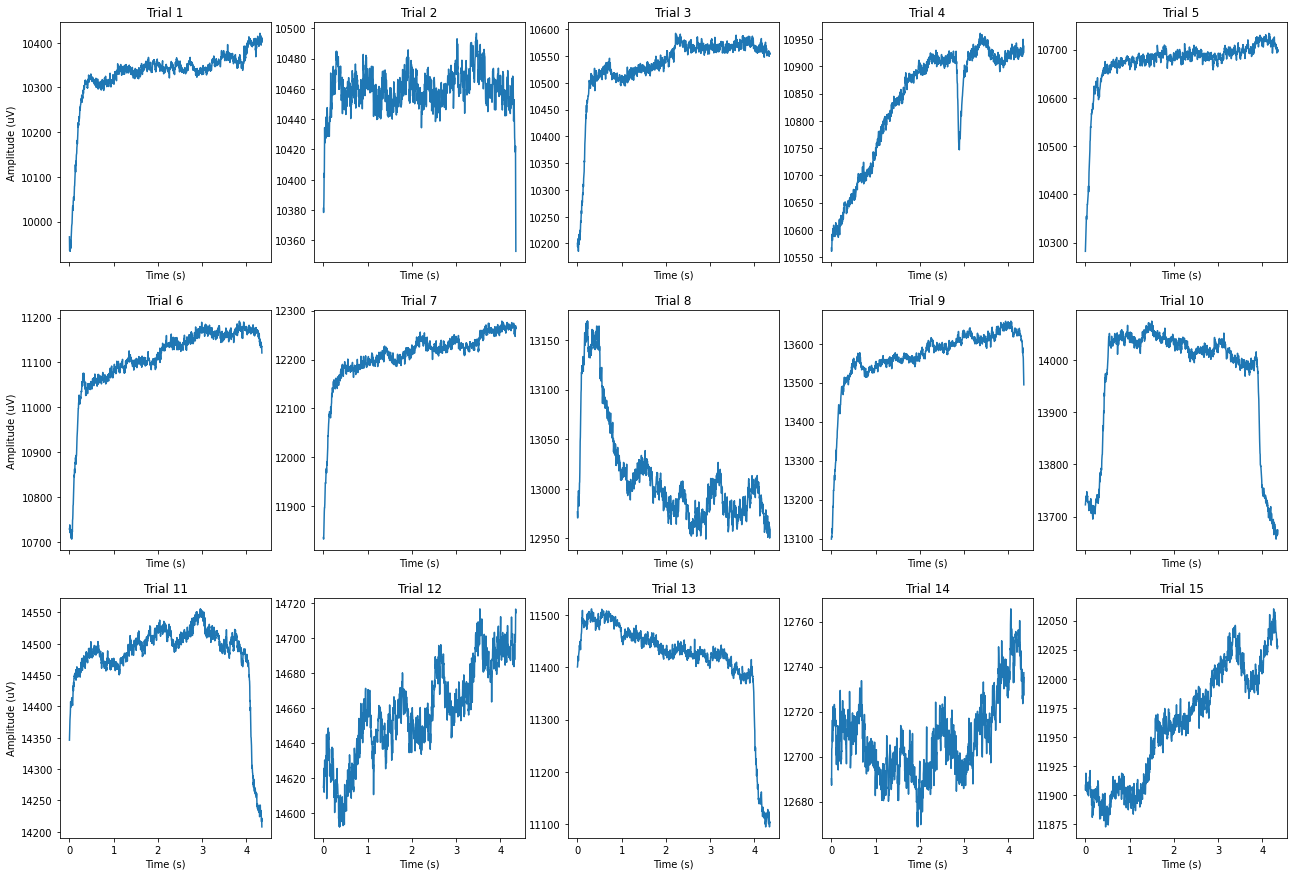

In [277]:
fig, ax = plt.subplots(3, 5, figsize=(22, 15), sharex=True, gridspec_kw={'wspace': 0.2})
ax = ax.reshape(-1)
time_axis = np.linspace(0, total_trial_s, total_trial_len)
for trial_index in range(num_trials):
    raw_eeg_trial = eeg[stim_index, CHANNEL_MAPPING[channel], :, trial_index]
    ax[trial_index].plot(time_axis, raw_eeg_trial)
    ax[trial_index].set_xlabel('Time (s)')
    ax[trial_index].set_title(f'Trial {trial_index+1}')
ax[0].set_ylabel('Amplitude (uV)')
ax[5].set_ylabel('Amplitude (uV)')
ax[10].set_ylabel('Amplitude (uV)');

### Time domain signal filtered in the band 0.1 Hz - 40 Hz

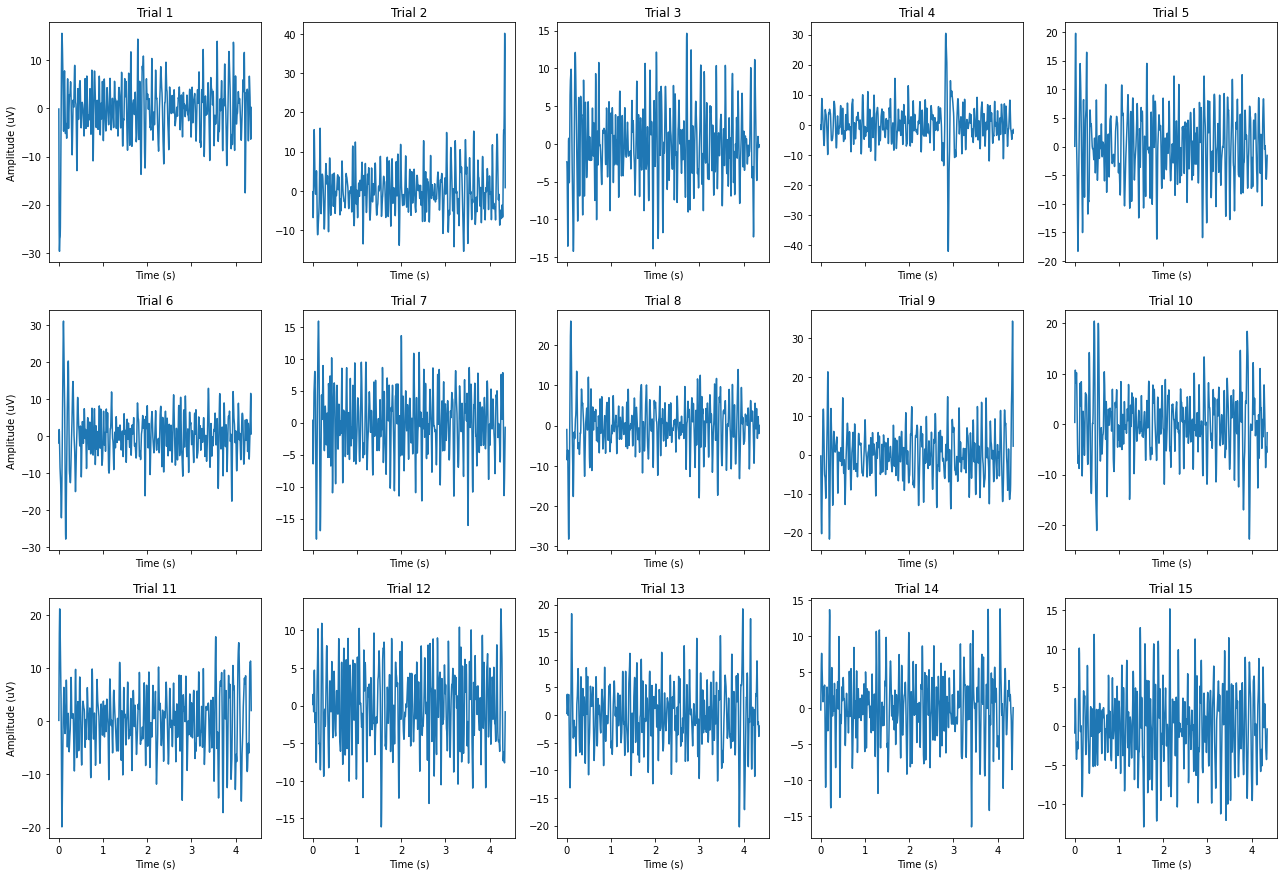

In [278]:
fig, ax = plt.subplots(3, 5, figsize=(22, 15), sharex=True, gridspec_kw={'wspace': 0.2})
ax = ax.reshape(-1)
time_axis = np.linspace(0, total_trial_s, total_trial_len)
for trial_index in range(num_trials):
    raw_eeg_trial = eeg[stim_index, CHANNEL_MAPPING[channel], :, trial_index]
    filtered_trial = su.butter_bandpass_filter(raw_eeg_trial, FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], sample_rate, 4)
    ax[trial_index].plot(time_axis, filtered_trial)
    ax[trial_index].set_xlabel('Time (s)')
    ax[trial_index].set_title(f'Trial {trial_index+1}')
ax[0].set_ylabel('Amplitude (uV)')
ax[5].set_ylabel('Amplitude (uV)')
ax[10].set_ylabel('Amplitude (uV)');

### Frequency Domain Representation of the filtered signal

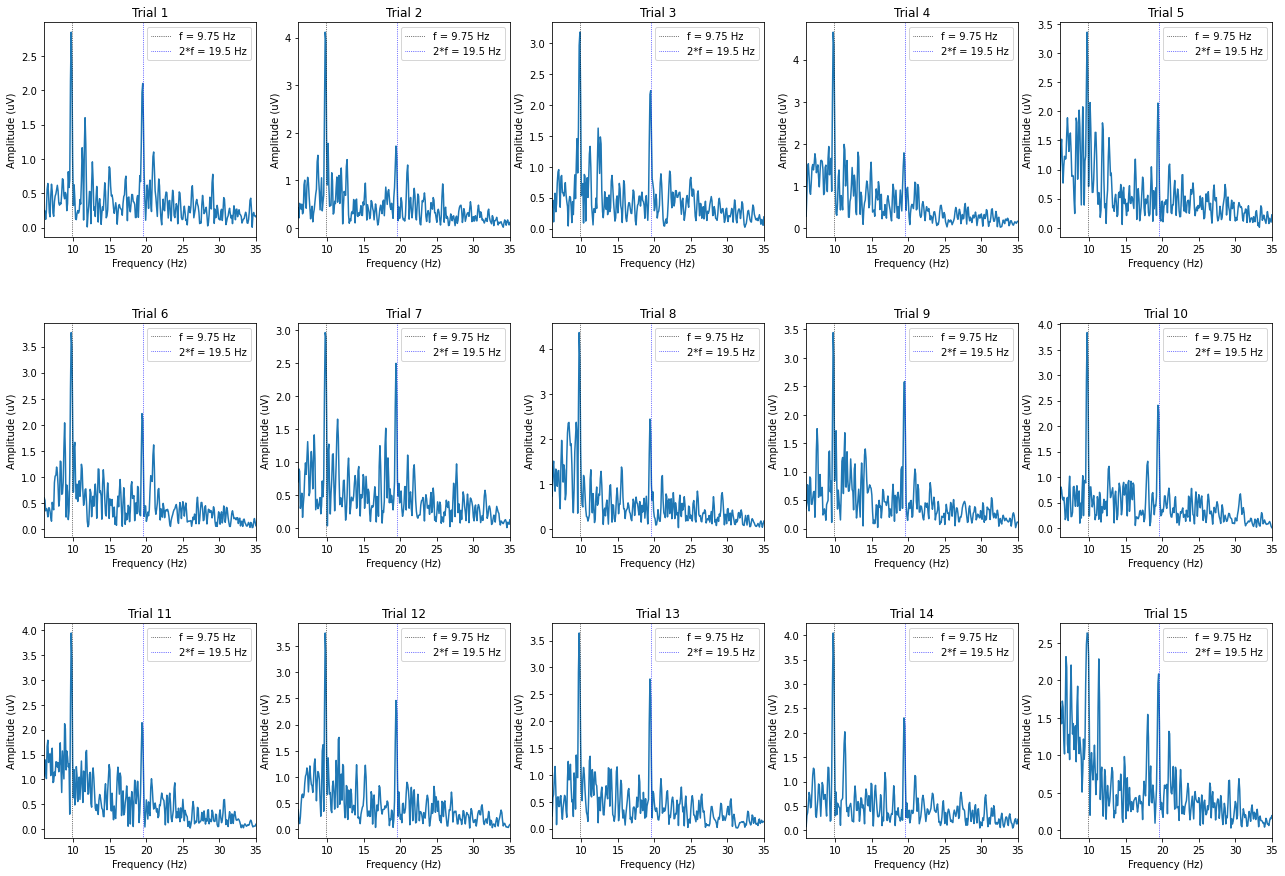

In [279]:
NFFT = round(FFT_PARAMS['sampling_rate']/FFT_PARAMS['resolution'])
fft_index_start = int(round(FFT_PARAMS['start_frequency']/FFT_PARAMS['resolution']))
fft_index_end = int(round(FFT_PARAMS['end_frequency']/FFT_PARAMS['resolution']))+1

fig, ax = plt.subplots(3, 5, figsize=(22, 15), gridspec_kw={'hspace': 0.4})
ax = ax.reshape(-1)
time_axis = np.linspace(0, total_trial_s, total_trial_len)
for trial_index in range(num_trials):
    filtered_trial = filtered_data[stim_index, CHANNEL_MAPPING[channel], :, trial_index]
    fft_len = filtered_trial.shape[0]
    complex_fft = np.fft.fft(filtered_trial, NFFT)/fft_len
    magnitude_spectrum = 2*np.abs(complex_fft)[fft_index_start:fft_index_end]
    fft_axis = np.linspace(FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], magnitude_spectrum.shape[0])
    ax[trial_index].plot(fft_axis, magnitude_spectrum)
    ax[trial_index].axvline(stim_freq, linestyle=':', linewidth=0.7, c='k', label=f'f = {stim_freq} Hz')
    ax[trial_index].axvline(2*stim_freq, linestyle=':', linewidth=0.7, c='b', label=f'2*f = {2*stim_freq} Hz')
    ax[trial_index].set_title(f'Trial {trial_index+1}')
    ax[trial_index].set_ylabel('Amplitude (uV)')
    ax[trial_index].set_xlabel('Frequency (Hz)')
    ax[trial_index].set_xlim(fft_axis[0], fft_axis[-1])
    ax[trial_index].legend()

### Average FFT across all trials and classes

In [280]:
magnitude_spectrum_for_all_subjects = dict()
for subject in [2, 5, 8]:
    dataset = sio.loadmat(f'{data_path}/s{subject}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')
    
    num_classes = eeg.shape[0]
    n_ch = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    
    filtered_data = su.get_filtered_eeg(eeg, FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], 4, sample_rate)
    segmented_data = su.get_segmented_epochs(filtered_data, window_len, shift_len, sample_rate)
    magnitude_spectrum_for_all_subjects[f's{subject}'] = su.magnitude_spectrum_features(segmented_data, FFT_PARAMS)

In [281]:
print(f'Subject IDs computed for: {magnitude_spectrum_for_all_subjects.keys()}')
subject_8_data = magnitude_spectrum_for_all_subjects['s8']
print(f'Shape of the array computed for one subject: {subject_8_data.shape}')
print(f'Frequency dimension: {subject_8_data.shape[0]}')
print(f'Number of channels: {subject_8_data.shape[1]}')
print(f'Number of classes: {subject_8_data.shape[2]}')
print(f'Number of trials: {subject_8_data.shape[3]}')

Subject IDs computed for: dict_keys(['s2', 's5', 's8'])
Shape of the array computed for one subject: (291, 8, 12, 15, 1)
Frequency dimension: 291
Number of channels: 8
Number of classes: 12
Number of trials: 15


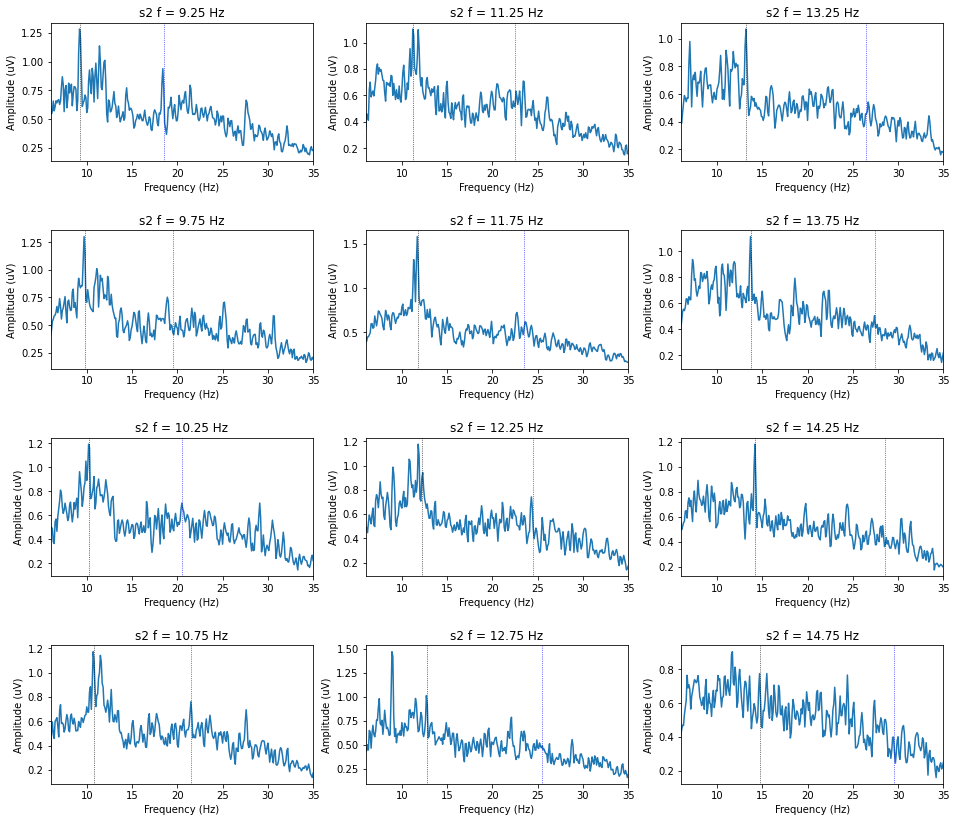

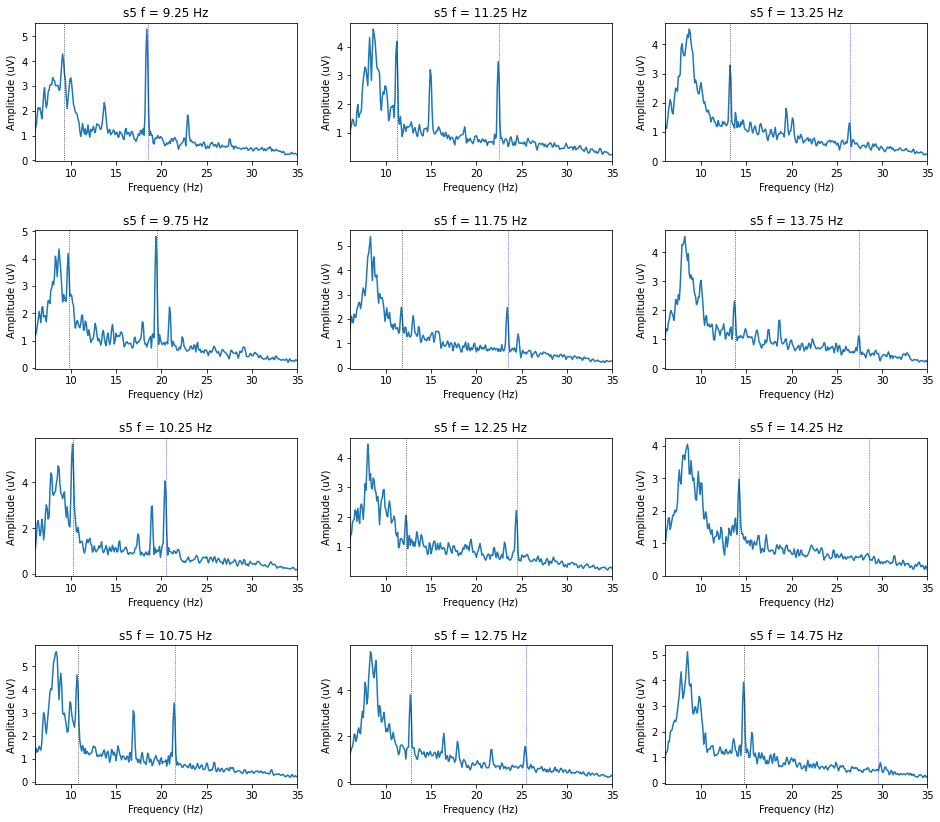

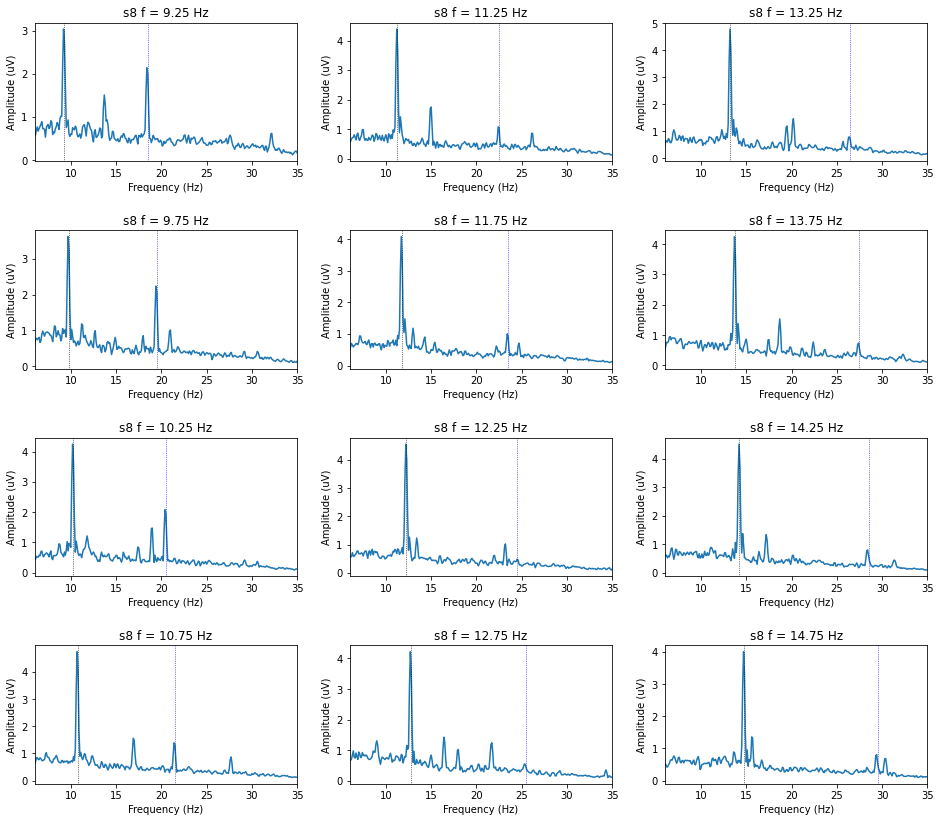

In [297]:
for subject_id, magnitude_spectrum in magnitude_spectrum_for_all_subjects.items():
    plot_spectrum(magnitude_spectrum, num_classes, subject_id, CHANNEL_MAPPING['OZ'], flicker_freq)

#### Observations
S5 has very high power in the alpha band

### Pick the dominant peak and assign the class label for this dataset from the FFT based on a single channel Oz

### Hints: 
1. Pick the maximum peak from each trial and compare it with all known frequencies (Trivial approach).
2. Pick the values at all known frequencies and pick the maximum among them (Slightly better approach).

#### Observations
Please note any observations from the results you generated

In [305]:
ground_truth_labels_dict = dict()
predicted_labels_dict = dict()
channel_idx = CHANNEL_MAPPING['OZ']

frequency_indexes_to_check = []
for val in flicker_freq:
    frequency_indexes_to_check.append(np.argmin(np.abs(fft_axis - val)))
    
for subject_id, magnitude_spectrum in magnitude_spectrum_for_all_subjects.items():
    predicted_labels_dict[subject_id] = []
    ground_truth_labels_dict[subject_id] = []
    single_channel_data = np.squeeze(magnitude_spectrum[:, channel_idx, :, :])
    fft_axis = np.linspace(FFT_PARAMS['start_frequency'], FFT_PARAMS['end_frequency'], magnitude_spectrum.shape[0])
    print(f'Single channel data dimensions: {single_channel_data.shape} for subj_id: {subject_id}')
    for class_idx in range(single_channel_data.shape[1]):
        for trial_idx in range(single_channel_data.shape[2]):
            #find the dominant frequency with the help of the fft_axis variable
            #the predicted class label is a value between 0 and 11 corresponding to the order in the flicker_freq array
            
            #Approach 1
            # max_index = np.argmax(single_channel_data[:, class_idx, trial_idx])
            # dominant_freq = fft_axis[max_index]
            # predicted_class = np.argmin(np.abs(dominant_freq - flicker_freq))
            
            #Approach 2
            max_index = np.argmax(single_channel_data[frequency_indexes_to_check, class_idx, trial_idx])
            dominant_freq = fft_axis[frequency_indexes_to_check[max_index]]
            predicted_class = np.argmin(np.abs(dominant_freq - flicker_freq))
            
            predicted_labels_dict[subject_id].append(predicted_class)
            ground_truth_labels_dict[subject_id].append(class_idx)

Single channel data dimensions: (291, 12, 15) for subj_id: s2
Single channel data dimensions: (291, 12, 15) for subj_id: s5
Single channel data dimensions: (291, 12, 15) for subj_id: s8


### Performance Evaluation

Subject ID: s2 - Accuracy: 32.77777777777778 %


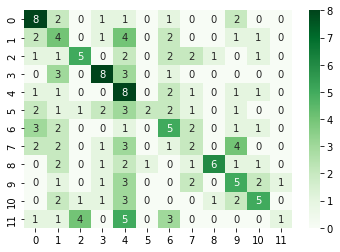

Subject ID: s5 - Accuracy: 42.22222222222222 %


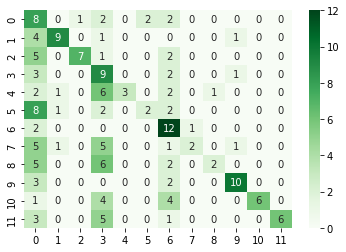

Subject ID: s8 - Accuracy: 99.44444444444444 %


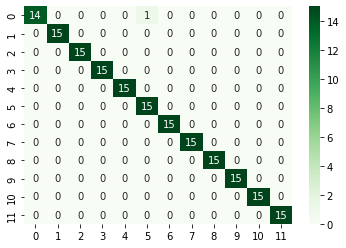

In [306]:
accuracy_dict = dict()
for subject_id in ground_truth_labels_dict.keys():
    accuracy_dict[subject_id] = plot_performance(ground_truth_labels_dict, predicted_labels_dict, subject_id)
    plt.show()

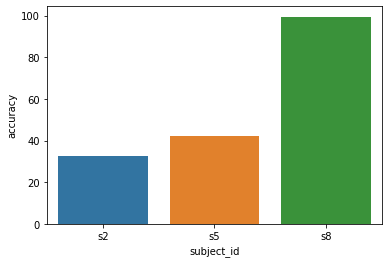

In [321]:
accuracy_df = pd.DataFrame({'subject_id': list(accuracy_dict.keys()), 'accuracy': list(accuracy_dict.values())})
sns.barplot(data=accuracy_df, x='subject_id', y='accuracy');

### Discussion

### How would you improve the performance of this classifier?
- Picking the dominant peak is a very simplistic approach
- Increase resolution of the FFT
- Use more channels
- Extract more robust features, not just dominant peak, but also the first harmonic
- Use a better classification technique

### What are some disadvantages of the current system?
- Too slow - we are using 4 seconds of data to predict the class label - slow system
